In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append('/Users/Josh/Documents/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

## Import training data

In [4]:
import pickle

with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [5]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [6]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

images_all = np.concatenate(sf_list, axis=0)

images_all.shape

(217802, 36, 36)

In [7]:
images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((185131, 36, 36), (185131,)), ((32671, 36, 36), (32671,)))

<IPython.core.display.Javascript object>


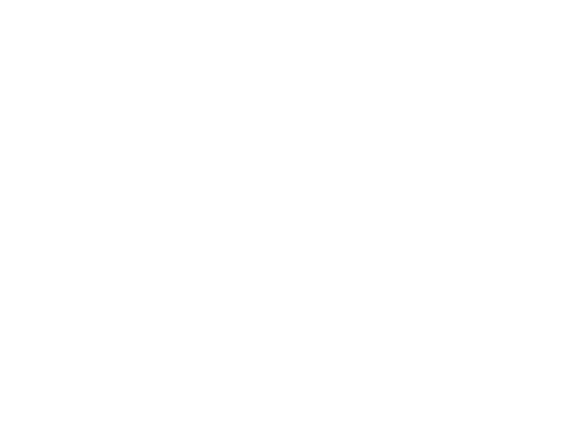

<IPython.core.display.Javascript object>


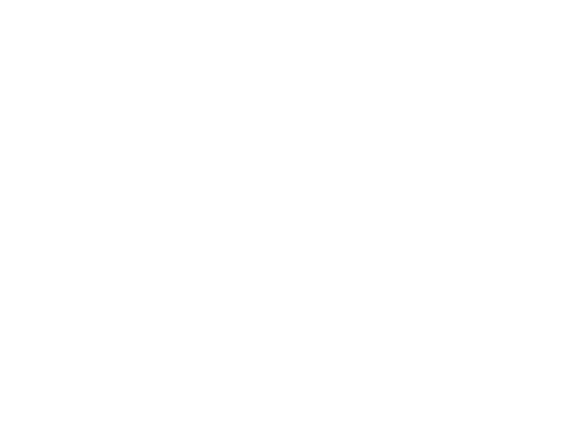

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


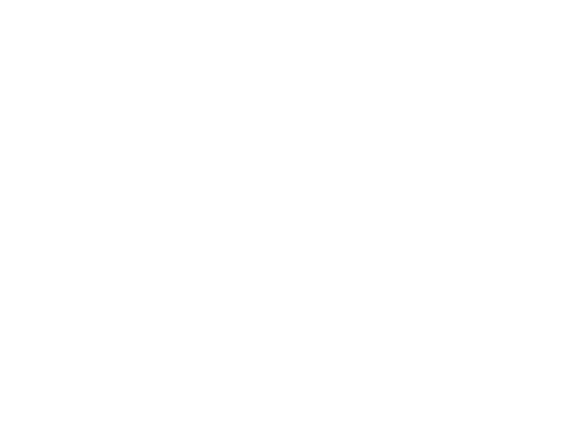

<IPython.core.display.Javascript object>


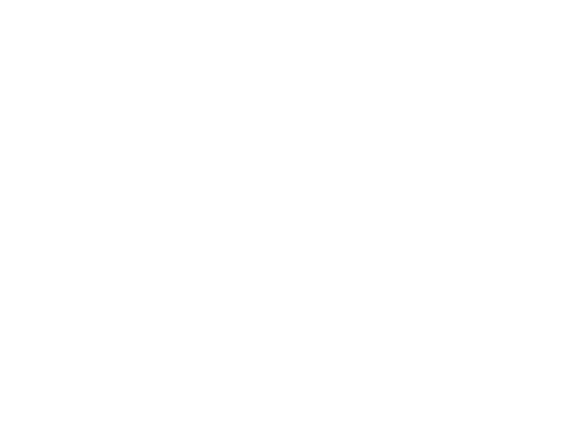

In [9]:
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

## Balance classes of inputs

In [10]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9715, 36, 36)
(9715,)
532
532
620
681
7881
(9715, 36, 36)
(9715,)


In [11]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_dup[:], labels_dup[:], test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((8257, 36, 36), (8257,)), ((1458, 36, 36), (1458,)))

<IPython.core.display.Javascript object>


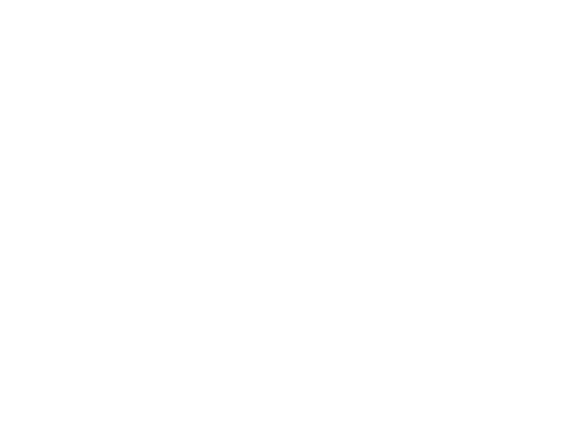

In [12]:
plt.figure()
plt.hist(labels_dup, 20);

## Define augmentation pipeline

In [21]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.5)),
    
#     torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.3, 0.3),
#                                         scale=(0.7, 1.7), 
#                                         shear=(-30, 30, -30, 30), 
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
    
#     augmentation.AddPoissonNoise(   level_bounds=(0,0.7),
#                                     prob=1),

#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.4,
#                                     prob=1),
)
# scripted_transforms = torch.jit.script(transforms)
scripted_transforms = transforms



dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1024,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=False,
#                                                 num_workers=32,
                                                num_workers=0,
#                                                 num_workers=16,
#                                                 prefetch_factor=3,
#                                                 persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

0.00018596649169921875


<IPython.core.display.Javascript object>


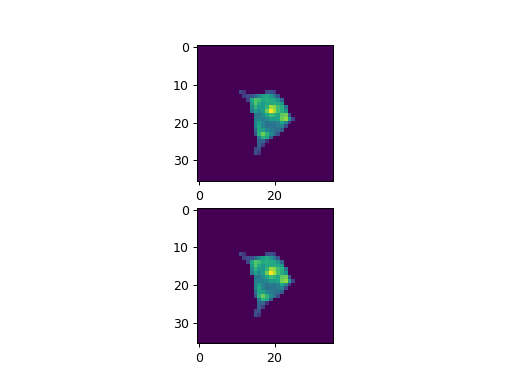

0.0386350154876709


<IPython.core.display.Javascript object>


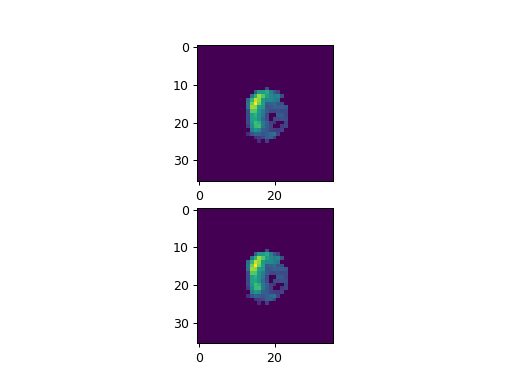

0.03654766082763672


<IPython.core.display.Javascript object>


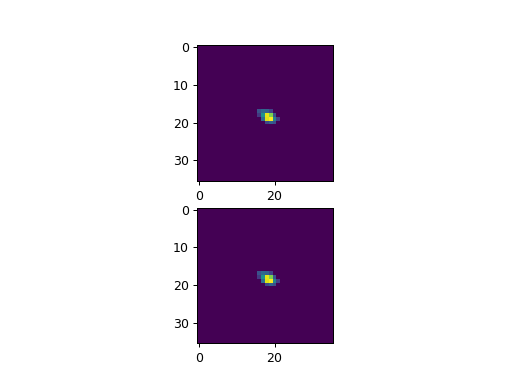

0.03518795967102051


<IPython.core.display.Javascript object>


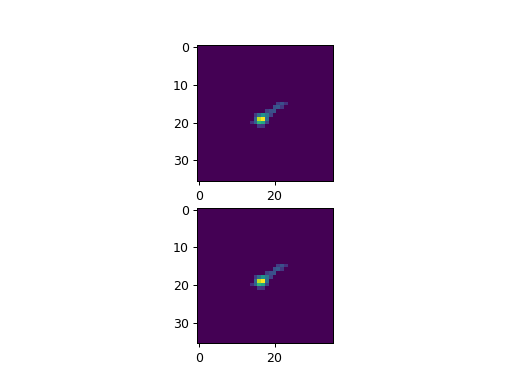

In [22]:
import time

%matplotlib notebook
tic=time.time()
for ii, im in enumerate(dataset_train):
#     for jj in range(im[0])
    print(time.time() - tic)
    tic = time.time()
#     print((im[0][0]).shape)
    fig, axs = plt.subplots(len(im[0]))
    for jj, ax in enumerate(axs):
        ax.imshow(im[0][jj].cpu().squeeze())
    if ii > 2:
        break

## Train

In [14]:
DEVICE = torch_helpers.set_device(use_GPU=True)

no GPU available. Using CPU.


In [75]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=128)
model.train()
# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0005,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [76]:
sys.path.append('/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/')

In [99]:
import numpy as np
from training_classHead import HeadModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# classHead = HeadModel(model, RandomForestClassifier)
classHead = HeadModel(model, LogisticRegression)
dataset_train.headmodel = classHead

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=10,
                               )
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
    classHead.fit(X_train[:, None, :, :], y_train)
    
    proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
    final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
    print(class_weights)

    dataset_train.set_classweights(final_weights)
    
    print('dataset_train.final_weights', dataset_train.class_weights)


epoch: 0
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
Iter: 0/8, loss_train: 1.1879e+04, loss_val: nan, lr: 0.00085982
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])


/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 1
double_sample_weights tensor([0.2881, 0.2000, 0.2000,  ..., 0.2000, 0.2044, 0.2000],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2722.1, loss_val: nan, lr: 0.00085638
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.3473, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2001, 0.2000, 0.2000,  ..., 0.2019, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2011, 0.2001, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2450, 0.2000,  ..., 0.3303, 0.3560, 0.2003],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2002,  ..., 0.2645, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 2
double_sample_weights tensor([0.2000, 0.2000, 0.2457,  ..., 0.2001, 0.2000, 0.2355],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2713.8, loss_val: nan, lr: 0.00085296
double_sample_weights tensor([0.2006, 0.3637, 0.2231,  ..., 0.2000, 0.2000, 0.2003],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2002, 0.2000,  ..., 0.2000, 0.2000, 0.3408],
       dtype=torch.float64)
double_sample_weights tensor([0.2010, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2001, 0.3535, 0.3271,  ..., 0.2002, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.3675],
       dtype=torch.float64)
double_sample_weights tensor([0.2602, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 3
double_sample_weights tensor([0.2001, 0.2992, 0.2832,  ..., 0.2000, 0.3032, 0.2000],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2672.8, loss_val: nan, lr: 0.00084956
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2910, 0.2000, 0.2615],
       dtype=torch.float64)
double_sample_weights tensor([0.2890, 0.3327, 0.2000,  ..., 0.2011, 0.2000, 0.3229],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.3192, 0.3848,  ..., 0.2000, 0.3281, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.3277, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2001],
       dtype=torch.float64)
double_sample_weights tensor([0.3259, 0.2000, 0.2000,  ..., 0.2383, 0.2000, 0.2691],
       dtype=torch.float64)
double_sample_weights tensor([0.2022, 0.2000, 0.2000,  ..., 0.2000, 0.3400, 0.2000],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 4
double_sample_weights tensor([0.3570, 0.3361, 0.2008,  ..., 0.2000, 0.2000, 0.3000],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2691.9, loss_val: nan, lr: 0.00084616
double_sample_weights tensor([0.2000, 0.3073, 0.2011,  ..., 0.2000, 0.2000, 0.2001],
       dtype=torch.float64)
double_sample_weights tensor([0.2001, 0.2000, 0.2000,  ..., 0.2000, 0.3743, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2028, 0.2000, 0.2000,  ..., 0.3539, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.3399, 0.2000,  ..., 0.2006, 0.2126, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2003, 0.2046, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2187, 0.2000,  ..., 0.3119, 0.2000, 0.3793],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 5
double_sample_weights tensor([0.2000, 0.2060, 0.3279,  ..., 0.3030, 0.2000, 0.2391],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2693.1, loss_val: nan, lr: 0.00084279
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2002, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.3157, 0.2000, 0.2528,  ..., 0.2416, 0.2000, 0.3509],
       dtype=torch.float64)
double_sample_weights tensor([0.2005, 0.2000, 0.2000,  ..., 0.2000, 0.2001, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2267, 0.3406],
       dtype=torch.float64)
double_sample_weights tensor([0.3263, 0.2000, 0.2000,  ..., 0.2000, 0.3201, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.3588, 0.2000, 0.2000,  ..., 0.2000, 0.2002, 0.2000],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 6
double_sample_weights tensor([0.2000, 0.3113, 0.2000,  ..., 0.2000, 0.3118, 0.2917],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2680.0, loss_val: nan, lr: 0.00083942
double_sample_weights tensor([0.2000, 0.2988, 0.2000,  ..., 0.2000, 0.2069, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2685, 0.2000, 0.2000,  ..., 0.2001, 0.2588, 0.3232],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2001,  ..., 0.2000, 0.3283, 0.2003],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2002,  ..., 0.2000, 0.2000, 0.2122],
       dtype=torch.float64)
double_sample_weights tensor([0.3550, 0.2000, 0.2000,  ..., 0.2012, 0.2390, 0.2002],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.3011],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 7
double_sample_weights tensor([0.2000, 0.2000, 0.3470,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2634.7, loss_val: nan, lr: 0.00083607
double_sample_weights tensor([0.2006, 0.2000, 0.3229,  ..., 0.2001, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2672, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.3437, 0.2000, 0.2000,  ..., 0.3384, 0.3525, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2011, 0.2000,  ..., 0.2000, 0.2000, 0.2006],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2001,  ..., 0.2006, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2307, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 8
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.3532, 0.3234, 0.2000],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2689.4, loss_val: nan, lr: 0.00083273
double_sample_weights tensor([0.2000, 0.3110, 0.2000,  ..., 0.2000, 0.2612, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2013, 0.2002, 0.2849,  ..., 0.3512, 0.2003, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.3353, 0.3626, 0.2757,  ..., 0.2000, 0.3365, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2087, 0.2001, 0.2000,  ..., 0.2000, 0.2594, 0.2000],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2748, 0.2000,  ..., 0.2000, 0.2000, 0.2001],
       dtype=torch.float64)
double_sample_wei

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 9
double_sample_weights tensor([0.2000, 0.2395, 0.2000,  ..., 0.3470, 0.2000, 0.2000],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2661.7, loss_val: nan, lr: 0.0008294
double_sample_weights tensor([0.2877, 0.2001, 0.2001,  ..., 0.2000, 0.2892, 0.2108],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.3108, 0.3395,  ..., 0.2000, 0.3323, 0.2537],
       dtype=torch.float64)
double_sample_weights tensor([0.3590, 0.2000, 0.2014,  ..., 0.2000, 0.2002, 0.2014],
       dtype=torch.float64)
double_sample_weights tensor([0.2020, 0.2358, 0.3507,  ..., 0.2000, 0.2493, 0.2020],
       dtype=torch.float64)
double_sample_weights tensor([0.2000, 0.2000, 0.2000,  ..., 0.2254, 0.2000, 0.2901],
       dtype=torch.float64)
double_sample_weights tensor([0.2001, 0.3208, 0.2000,  ..., 0.2002, 0.2075, 0.2000],
       dtype=torch.float64)
double_sample_weig

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 444.98675998  529.96575738 8257.          577.04739082 6703.99609642]
dataset_train.final_weights [0.2 0.2 0.2 0.2 0.2]
epoch: 10
double_sample_weights tensor([0.2000, 0.3465, 0.2123,  ..., 0.2596, 0.2000, 0.2004],
       dtype=torch.float64)
Iter: 0/8, loss_train: 2676.7, loss_val: nan, lr: 0.00082609


KeyboardInterrupt: 

In [100]:

# vecs = torch.tensor(np.array([[-1,0.5], [0.5, 1], [0.5, 0.5]]))

# queries = torch.stack(torch.meshgrid(torch.arange(-1.5,1.5, 0.02), torch.arange(-1.5,1.5, 0.02)), dim=-1)
# # print(queries.shape)
# q_flat = queries.reshape(queries.shape[0]*queries.shape[1], -1)
# # print(q_flat.shape)

# sims = (q_flat.double() @ vecs.T) / torch.outer(torch.norm(q_flat.double(), dim=1), torch.norm(vecs, dim=1))
# # print(sims.shape)
# # print(sims)
# soft_temp = 10
# proba = torch.nn.functional.softmax(sims*soft_temp, dim=1)
# unc = util.loss_uncertainty(proba, temperature=1)

# # print(proba.sum(axis=1))
# print(unc)

# plt.figure()
# plt.scatter(q_flat[:,0], q_flat[:,1], c=proba)
# plt.scatter(vecs[:,0], vecs[:,1], c='k')

# plt.figure()
# plt.scatter(q_flat[:,0], q_flat[:,1], c=unc)
# plt.scatter(vecs[:,0], vecs[:,1], c='k')

In [101]:
# [A, B, C]
# [a, b, b]
# [100, 50, 50]
# x = 100
# [x, x/2, x/2]
# [1, 2, 2]

# [1/5, 2/5, 2/5]


In [102]:
# import numpy as np
# from training_classHead import HeadModel

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix

# import torchvision.transforms    

# transforms = torch.nn.Sequential()
# scripted_transforms = transforms


# dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
#                                     y_train, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=1024,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=False,
#                                                 num_workers=0,
# #                                                 num_workers=16,
# #                                                 prefetch_factor=3,
# #                                                 persistent_workers=True,
#                                                 )


# classHead = HeadModel(model, LogisticRegression)
# dataset_train.set_headmodel(classHead)

# n_epochs=300000

# i_batch = 0
# dl = dataset_train.__getitem__(0)
# # if True:

# # for i_batch, (X_batch, y_batch, idx_batch, sample_weight) in enumerate(dataloader_train):
# for i_batch, (dl) in enumerate(dataloader_train):
# #     print(X_batch)
# #     print(y_batch)
# #     print(idx_batch)
# #     print(sample_weight)
#     print(dl)
    
#     classHead.fit(X_train[:, None, :, :], y_train)
#     dataset_train.set_headmodel(classHead)
#     preds = classHead.predict(X_train[:, None, :, :])
    
#     class_weights = np.zeros((preds.shape[0], classHead.n_classes)).astype(int)
#     class_weights[np.arange(preds.shape[0]), preds] = 1
#     class_weights = class_weights.sum(axis=0)

#     total_num = class_weights.sum()

#     class_weights[class_weights == 0] = total_num
#     class_weights[class_weights == 1] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)
    
    
#     sample_weight = torch.tensor([1.0], device=dataset_train.X.device)

#     if dataset_train.headmodel is not None and dataset_train.headmodel.n_classes is not None:
#         prediction = dataset_train.headmodel.predict(dataset_train.X[0:16])
#         print(prediction)
#         onehot_prediction = np.eye(dataset_train.headmodel.n_classes)[prediction]
#         print(onehot_prediction)
#         sample_weight = onehot_prediction * dataset_train.class_weights
#         print(sample_weight)
#         sample_weight = torch.tensor(sample_weight, device=dataset_train.X.device)
#         print(sample_weight)
#         sample_weight = sample_weight.sum(axis=-1)
#         print(sample_weight)

#     print(dataset_train)

In [103]:
# dataloader_train.class_weights

In [104]:
# for dl in dataloader_train:
#     print(dl)

In [105]:

# classHead.fit(X_train[:, None, :, :], y_train)
# preds = classHead.predict(X_train[:, None, :, :])

# class_weights = np.zeros((preds.shape[0], classHead.n_classes)).astype(int)
# class_weights[np.arange(preds.shape[0]), preds] = 1
# class_weights = class_weights.sum(axis=0)

# total_num = class_weights.sum()

# class_weights[class_weights == 0] = total_num
# class_weights[class_weights == 1] = total_num
# weightings = class_weights.sum()/class_weights
# final_weights = weightings / weightings.sum()

# dataset_train.set_classweights(final_weights)

# # print(weightings)
# # dataset_train.set_classweights(classHead)

In [106]:
# final_weights

In [107]:
# class_weights

In [108]:
# logreg = RandomForestClassifier()
# logreg.fit(classHead.get_simCLR_head(X_train[:,None,:,:]), y_train)
# logreg.classes_

In [109]:
# n_epochs=300000
# for epoch in range(n_epochs):
#     print(f'epoch: {epoch}')
#     training_simCLR.epoch_step( dataloader_train, 
#                                 model, 
#                                 optimizer, 
#                                 criterion, 
#                                 scheduler=scheduler, 
#                                 temperature=0.5,
#                                 loss_rolling_train=losses_train, 
#                                 device=DEVICE, 
#                                 do_validation=False,
#                                 validation_Object=val_obj,
#                                 loss_rolling_val=losses_val,
#                                 verbose=2,
#                                 verbose_update_period=10,
#                                )
#     # model predict
#     # Update model in DS
#     # get item calls model for each sample
#     # output
#     # X sample weights predictions
    
    


In [110]:
# load_mdl = torch.load('/Users/josh/Documents/Harvard/pretrained/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth',
#                  map_location=torch.device('cpu'))
# model.load_state_dict(load_mdl)
# # model.load_state_dict('/Users/josh/Documents/Harvard/pretrained/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [111]:
# plt.figure()
# plt.plot(losses_train)

In [112]:
# for v in (dataloader_train):
#     print(v)
#     print(len(v))
#     model(v)
#     break

# model(torch.tensor(X_train[:,None,:,:]).float())
# tm = training_classHead.get_simCLR_interim(model, X_train[:, None, :, :])
# tm = training_classHead.get_simCLR_output(model, X_train[:, None, :, :])

In [113]:
# tm.shape

In [114]:
# import training_classHead

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix


# # # import training_classHead
# # from training_classHead import HeadModel

# # from sklearn.linear_model import LogisticRegression
# # from sklearn.tree import DecisionTreeClassifier
# # from sklearn.ensemble import RandomForestClassifier
# # from sklearn.svm import SVC
# # from sklearn.metrics import confusion_matrix

# # exp_X_train = X_train[:, None, :, :]
# # exp_X_val = X_val[:, None, :, :]

# # classHead = HeadModel(model, RandomForestClassifier).train(exp_X_train, y_train)
# # prediction = classHead.predict(exp_X_val)

# # print(classHead.score(exp_X_val, y_val))

# # cm = confusion_matrix(y_val, prediction)
# # print(cm)
# # print(cm/cm.sum(axis=0))

# # # prediction_proba = classHead.predict_proba(exp_X_val)



# PredictionClass = RandomForestClassifier
# logreg = training_classHead.train_head(model, PredictionClass, X_train[:, None, :, :], y_train)
# prediction_proba = training_classHead.predict(model, logreg, X_val[:,None,...])
# prediction = training_classHead.predict(model, logreg, X_val[:,None,...])

# print(confusion_matrix(y_val, prediction))
# print(logreg.score(training_classHead.get_simCLR_head(model, X_val[:,None,:,:]), y_val))

# prediction = training_classHead.predict(model, logreg, X_val[:,None,...])

# cm = confusion_matrix(y_val, prediction)
# print(cm/cm.sum(axis=0))

In [115]:
# ROC on Dendrite Classification
# Goal: Accuracy / Precision of Dendrite Classification is most important

In [116]:
# import pandas as pd
# with pd.option_context('max_rows', 3000):
#     display(pd.DataFrame(np.concatenate([y_val.reshape(-1,1), prediction.reshape(-1,1)], axis=1)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1458 and the array at index 1 has size 16

In [117]:
# training_classHead.get_simCLR_interim(model, X_val[:,None,:,:])

## Check embeddings

In [118]:
torch.cuda.empty_cache()

In [119]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [120]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [121]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=90.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [122]:
features_embedded

array([[ -6.546688  , -33.13777   ],
       [  1.5967838 , -49.82662   ],
       [-12.133478  , -33.96421   ],
       ...,
       [-18.72988   ,  26.638329  ],
       [ 32.791748  ,  -0.36960703],
       [  4.5011578 , -53.986095  ]], dtype=float32)

<IPython.core.display.Javascript object>


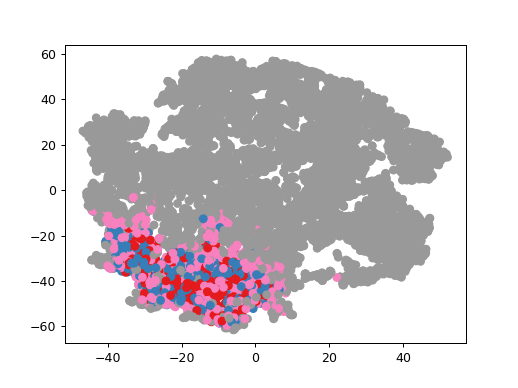

In [123]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [124]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


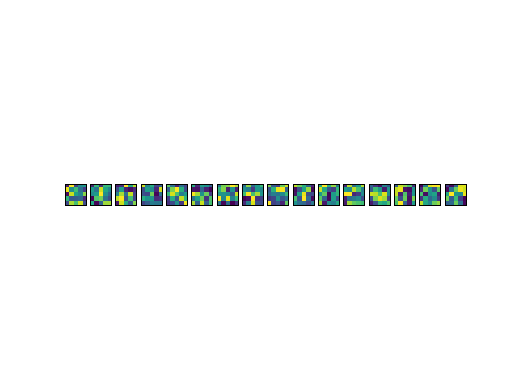

<IPython.core.display.Javascript object>


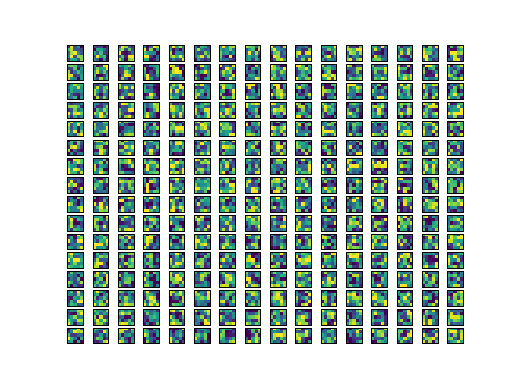

<IPython.core.display.Javascript object>


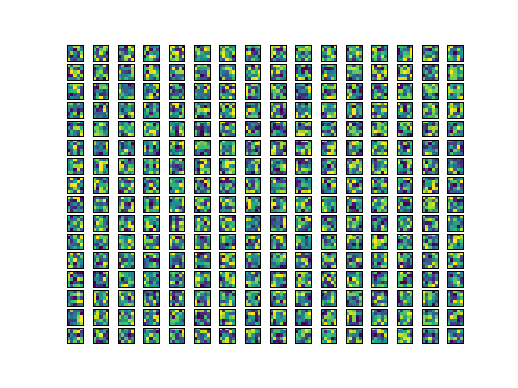

<IPython.core.display.Javascript object>


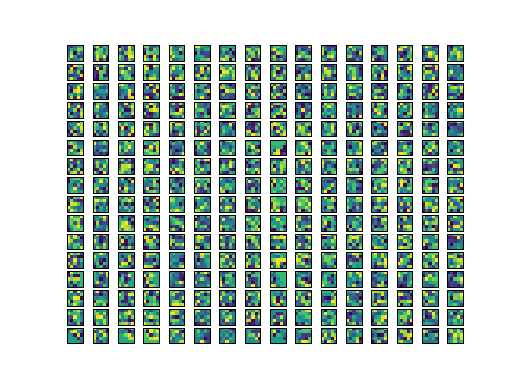

In [125]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [126]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [127]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()